In [1]:
 %matplotlib inline
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('./KB_mxxg/comb_pre_to_cat2.csv')

In [3]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], 1)

In [4]:
def gucode(path):
    gucode = {}
    df = pd.read_csv(path, sep=':',names=['name', 'code'])
    for i,code in enumerate(df['code']):
        gucode[code] = df['name'][i]
    return gucode

gucode = gucode('./KB_mxxg/gucode.txt')

In [5]:
gucode

{11110: '종로구',
 11140: '중구',
 11170: '용산구',
 11200: '성동구',
 11215: '광진구',
 11230: '동대문구',
 11260: '중랑구',
 11290: '성북구',
 11305: '강북구',
 11320: '도봉구',
 11350: '노원구',
 11380: '은평구',
 11410: '서대문구',
 11440: '마포구',
 11470: '양천구',
 11500: '강서구',
 11530: '구로구',
 11545: '금천구',
 11560: '영등포구',
 11590: '동작구',
 11620: '관악구',
 11650: '서초구',
 11680: '강남구',
 11710: '송파구',
 11740: '강동구'}

In [6]:
def idx_custom(custom_data, year_range, year_idx, code):
    custom_data = custom_data.iloc[year_idx]
    custom_data = custom_data.reset_index(drop=True)
    print('Only {} data in {} year(s)'.format(gucode[code], year_range))
    print('Data size : {}'.format(len(custom_data)))
    
    return custom_data, gucode[code]

In [8]:
def custom_data(code):
    #input gu-code & year
    min_year = int(input('start year: '))
    max_year = int(input('end year: '))
    
    gu_idx = np.where(data[str(code)]==1)[0]
    
    custom_data = data.iloc[gu_idx] #원하는 구만 잘라냄
    custom_data = custom_data.reset_index(drop=True) #index 0부터 다시 초기화
    year_range = []
    
    if max_year >= min_year:
        
        for year in range(min_year, max_year + 1):
            year_range.append(year)
            
        tmp = [np.where(custom_data['d_yr'] == year)[0] for year in year_range]
        year_idx = np.concatenate(tmp)

        return idx_custom(custom_data, year_range, year_idx, code)
        
    elif max_year == min_year:
        year_range.append(min_year)
        year_idx = np.where(custom_data['d_yr'] == year_range[0])[0]
        
        return idx_custom(custom_data,year_range, year_idx, code)
    else:
        return 0
    

In [9]:
gangnam, gu_name = custom_data(11680)

start year: 2010
end year: 2018
Only 강남구 data in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] year(s)
Data size : 20338


In [10]:
def datasplit(data):
    data = data.sample(frac=1).reset_index(drop=True) #shuffle
    data = data.reset_index(drop=True) #index 초기화
    
    train_len = int(len(data)*0.8)
    
    train = data.loc[:train_len-1]
    train = train.sample(frac=1).reset_index(drop=True) #shuffle
    train = train.reset_index(drop=True) #index 초기화
    
    test = data.loc[train_len:]
    test = test.sample(frac=1).reset_index(drop=True) #shuffle
    test = test.reset_index(drop=True)
    
    print ('{} data is splitted into {} train / {} test data'.format(len(data),len(train), len(test)))
    return train, test

In [11]:
train, test = datasplit(gangnam)

20338 data is splitted into 16270 train / 4068 test data


In [13]:
def make_x_y(data):
    x = data.drop(['price', 'avg_price'],1)
    y = data['price'].values
    
    print('Done')
    return x,y

In [14]:
x_train, y_train = make_x_y(train)
x_test, y_test = make_x_y(test)

Done
Done


/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


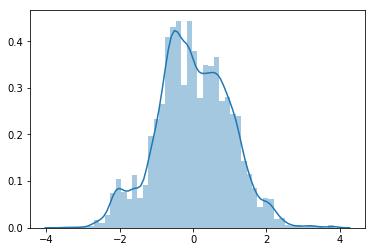

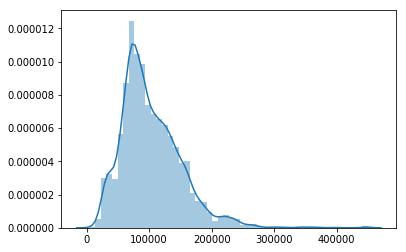

In [15]:
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y_train) #정규분포화
yt2 = johnson_inverse(yt, g, et, ep, l) #inverse 정규분포화
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers,optimizers,losses
from keras.layers.normalization import BatchNormalization

import datetime
import os

In [18]:
# path where all models are saved
now = datetime.datetime.now()
ymd = (str(now.year) + str(now.month) + str(now.day))

BASE_PATH = './'+gu_name+'_model_'+ymd+'/'
print(BASE_PATH)

MODEL_NAME = 'MLP_rmse'

if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50)

./강남구_model_20181117/


In [19]:
def custom_loss(y_true,y_pred):
    import keras.backend as K
    #loss = K.mean((y_true - y_pred)**2, axis=-1)
    loss = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''
    def _logcosh(x):
        return x + K.softplus(-2. * x) - K.log(2.)
    loss= K.mean(_logcosh(y_pred - y_true), axis=-1)
    '''
    return loss

In [20]:
def rmse(y_true,y_pred):
    import keras.backend as K
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [21]:
def rmsle(y_true, y_pred):
    import keras.backend as K
    first_log = K.log(y_pred + 1)
    second_log = K.log(y_true + 1)
    loss= K.sqrt(K.mean(K.square(first_log - second_log)))
    return loss

In [22]:
def rmsle_for_eval(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log(y_pred+1)-np.log(y_true+1))))

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
adam = optimizers.Adam(lr=0.0009, decay=0.0001)

In [24]:
def Model(x_train, y_train, batch_size, max_epochs):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=114))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=adam,
                  loss=rmse,
                  metrics=['accuracy'])

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    # Validation_split으로 validation 얼마나 해줄건지 정해중!
    history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=max_epochs,
                  validation_split = 0.1,
                  shuffle=True,
                  callbacks=[checkloss, early_stopping])
    
    return model, history

In [25]:
model = Model(x_train, yt, 32, 5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               14720     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
__________


Epoch 00031: val_loss did not improve from 0.57723
Epoch 32/5000
14643/14643 [==============================] - 2s 126us/step - loss: 0.3514 - acc: 0.0000e+00 - val_loss: 0.8361 - val_acc: 0.0000e+00

Epoch 00032: val_loss did not improve from 0.57723
Epoch 33/5000
14643/14643 [==============================] - 2s 128us/step - loss: 0.3459 - acc: 0.0000e+00 - val_loss: 0.4002 - val_acc: 0.0000e+00

Epoch 00033: val_loss improved from 0.57723 to 0.40022, saving model to ./강남구_model_20181117/MLP_rmse/val_loss-0.400220.hdf5
Epoch 34/5000
14643/14643 [==============================] - 2s 129us/step - loss: 0.3471 - acc: 0.0000e+00 - val_loss: 0.9470 - val_acc: 0.0000e+00

Epoch 00034: val_loss did not improve from 0.40022
Epoch 35/5000
14643/14643 [==============================] - 2s 125us/step - loss: 0.3499 - acc: 0.0000e+00 - val_loss: 0.8188 - val_acc: 0.0000e+00

Epoch 00035: val_loss did not improve from 0.40022
Epoch 36/5000
14643/14643 [==============================] - 2s 129us/

14643/14643 [==============================] - 2s 147us/step - loss: 0.2954 - acc: 0.0000e+00 - val_loss: 0.6356 - val_acc: 0.0000e+00

Epoch 00071: val_loss did not improve from 0.30445
Epoch 72/5000
14643/14643 [==============================] - 2s 120us/step - loss: 0.2933 - acc: 0.0000e+00 - val_loss: 0.3267 - val_acc: 0.0000e+00

Epoch 00072: val_loss did not improve from 0.30445
Epoch 73/5000
14643/14643 [==============================] - 2s 124us/step - loss: 0.2972 - acc: 0.0000e+00 - val_loss: 0.4282 - val_acc: 0.0000e+00

Epoch 00073: val_loss did not improve from 0.30445
Epoch 74/5000
14643/14643 [==============================] - 2s 129us/step - loss: 0.2936 - acc: 0.0000e+00 - val_loss: 0.3911 - val_acc: 0.0000e+00

Epoch 00074: val_loss did not improve from 0.30445
Epoch 75/5000
14643/14643 [==============================] - 2s 118us/step - loss: 0.2987 - acc: 0.0000e+00 - val_loss: 0.3859 - val_acc: 0.0000e+00

Epoch 00075: val_loss did not improve from 0.30445
Epoch 76/

14643/14643 [==============================] - 2s 113us/step - loss: 0.2740 - acc: 0.0000e+00 - val_loss: 0.4079 - val_acc: 0.0000e+00

Epoch 00110: val_loss did not improve from 0.21919
Epoch 111/5000
14643/14643 [==============================] - 2s 116us/step - loss: 0.2760 - acc: 0.0000e+00 - val_loss: 0.1986 - val_acc: 0.0000e+00

Epoch 00111: val_loss improved from 0.21919 to 0.19860, saving model to ./강남구_model_20181117/MLP_rmse/val_loss-0.198601.hdf5
Epoch 112/5000
14643/14643 [==============================] - 2s 117us/step - loss: 0.2772 - acc: 0.0000e+00 - val_loss: 0.2952 - val_acc: 0.0000e+00

Epoch 00112: val_loss did not improve from 0.19860
Epoch 113/5000
14643/14643 [==============================] - 2s 116us/step - loss: 0.2710 - acc: 0.0000e+00 - val_loss: 0.2253 - val_acc: 0.0000e+00

Epoch 00113: val_loss did not improve from 0.19860
Epoch 114/5000
14643/14643 [==============================] - 2s 114us/step - loss: 0.2680 - acc: 0.0000e+00 - val_loss: 0.2521 - val

14643/14643 [==============================] - ETA: 0s - loss: 0.2650 - acc: 0.0000e+0 - 2s 136us/step - loss: 0.2650 - acc: 0.0000e+00 - val_loss: 0.1931 - val_acc: 0.0000e+00

Epoch 00150: val_loss improved from 0.19737 to 0.19314, saving model to ./강남구_model_20181117/MLP_rmse/val_loss-0.193136.hdf5
Epoch 151/5000
14643/14643 [==============================] - 2s 129us/step - loss: 0.2609 - acc: 0.0000e+00 - val_loss: 0.2352 - val_acc: 0.0000e+00

Epoch 00151: val_loss did not improve from 0.19314
Epoch 152/5000
14643/14643 [==============================] - 2s 141us/step - loss: 0.2560 - acc: 0.0000e+00 - val_loss: 0.2274 - val_acc: 0.0000e+00

Epoch 00152: val_loss did not improve from 0.19314
Epoch 153/5000
14643/14643 [==============================] - 2s 145us/step - loss: 0.2623 - acc: 0.0000e+00 - val_loss: 0.2974 - val_acc: 0.0000e+00

Epoch 00153: val_loss did not improve from 0.19314
Epoch 154/5000
14643/14643 [==============================] - 2s 115us/step - loss: 0.2626 


Epoch 00189: val_loss did not improve from 0.18867
Epoch 190/5000
14643/14643 [==============================] - 2s 124us/step - loss: 0.2475 - acc: 0.0000e+00 - val_loss: 0.2876 - val_acc: 0.0000e+00

Epoch 00190: val_loss did not improve from 0.18867
Epoch 191/5000
14643/14643 [==============================] - 2s 147us/step - loss: 0.2540 - acc: 0.0000e+00 - val_loss: 0.2197 - val_acc: 0.0000e+00

Epoch 00191: val_loss did not improve from 0.18867
Epoch 192/5000
14643/14643 [==============================] - 2s 132us/step - loss: 0.2619 - acc: 0.0000e+00 - val_loss: 0.1949 - val_acc: 0.0000e+00

Epoch 00192: val_loss did not improve from 0.18867
Epoch 193/5000
14643/14643 [==============================] - 2s 123us/step - loss: 0.2655 - acc: 0.0000e+00 - val_loss: 0.2333 - val_acc: 0.0000e+00

Epoch 00193: val_loss did not improve from 0.18867
Epoch 194/5000
14643/14643 [==============================] - 2s 133us/step - loss: 0.2567 - acc: 0.0000e+00 - val_loss: 0.2039 - val_acc: 0


Epoch 00229: val_loss did not improve from 0.18369
Epoch 230/5000
14643/14643 [==============================] - 3s 171us/step - loss: 0.2551 - acc: 0.0000e+00 - val_loss: 0.1962 - val_acc: 0.0000e+00

Epoch 00230: val_loss did not improve from 0.18369
Epoch 231/5000
14643/14643 [==============================] - 2s 133us/step - loss: 0.2558 - acc: 0.0000e+00 - val_loss: 0.1906 - val_acc: 0.0000e+00

Epoch 00231: val_loss did not improve from 0.18369
Epoch 232/5000
14643/14643 [==============================] - 2s 132us/step - loss: 0.2495 - acc: 0.0000e+00 - val_loss: 0.2147 - val_acc: 0.0000e+00

Epoch 00232: val_loss did not improve from 0.18369
Epoch 233/5000
14643/14643 [==============================] - 2s 126us/step - loss: 0.2482 - acc: 0.0000e+00 - val_loss: 0.1909 - val_acc: 0.0000e+00

Epoch 00233: val_loss did not improve from 0.18369
Epoch 234/5000
14643/14643 [==============================] - 2s 130us/step - loss: 0.2507 - acc: 0.0000e+00 - val_loss: 0.2176 - val_acc: 0

14643/14643 [==============================] - 2s 117us/step - loss: 0.2439 - acc: 0.0000e+00 - val_loss: 0.2163 - val_acc: 0.0000e+00

Epoch 00270: val_loss did not improve from 0.17763
Epoch 271/5000
14643/14643 [==============================] - 2s 114us/step - loss: 0.2446 - acc: 0.0000e+00 - val_loss: 0.2014 - val_acc: 0.0000e+00

Epoch 00271: val_loss did not improve from 0.17763
Epoch 272/5000
14643/14643 [==============================] - 2s 112us/step - loss: 0.2469 - acc: 0.0000e+00 - val_loss: 0.2049 - val_acc: 0.0000e+00

Epoch 00272: val_loss did not improve from 0.17763
Epoch 273/5000
14643/14643 [==============================] - 2s 104us/step - loss: 0.2560 - acc: 0.0000e+00 - val_loss: 0.1978 - val_acc: 0.0000e+00

Epoch 00273: val_loss did not improve from 0.17763
Epoch 274/5000
14643/14643 [==============================] - 2s 115us/step - loss: 0.2465 - acc: 0.0000e+00 - val_loss: 0.1981 - val_acc: 0.0000e+00

Epoch 00274: val_loss did not improve from 0.17763
Epoch

In [27]:
def plot_train(history):
    fig, loss_ax = plt.subplots(figsize=(10,10))

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')


    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')

    loss_ax.legend(loc='upper right')

    plt.show()
    
def test_summary(model, weight_path):
    plot_train(model[1])
    model[0].load_weights(weight_path)
    norm_y = g + et*np.arcsinh((y_test-ep)/l)
    loss, acc = model[0].evaluate(x_test, norm_y, batch_size=32)
    #loss, acc = model[0].evaluate(x_test, y_test, batch_size=32)
    print('----- Evaluation loss and metrics -----')
    print('Test loss - RMSE : {:.5f}'.format(loss))

In [28]:
CURR_PATH = BASE_PATH + MODEL_NAME + "/"

BEST_MODEL = sorted(os.listdir(CURR_PATH))[0]

FULL_PATH = CURR_PATH + BEST_MODEL

print(FULL_PATH)

./강남구_model_20181117/MLP_rmse/val_loss-0.177632.hdf5


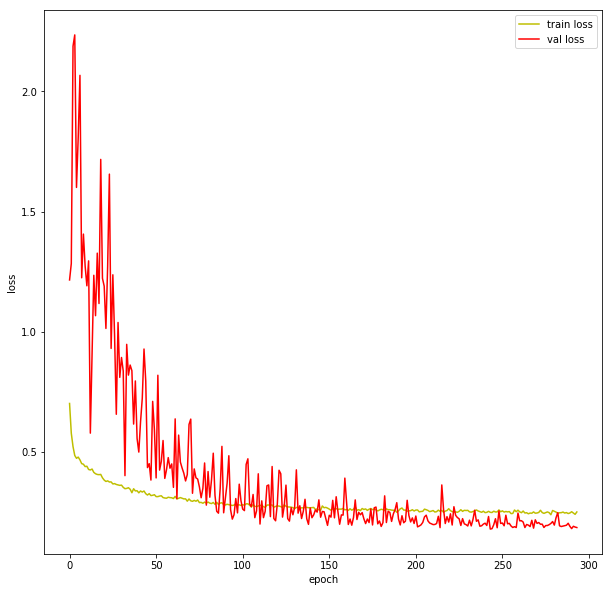

4068/4068 [==============================] - 0s 36us/step
----- Evaluation loss and metrics -----
Test loss - RMSE : 0.17771


In [29]:
test_summary(model,FULL_PATH)

In [37]:
def prediction_plot(n_sample):
    from sklearn.metrics import r2_score

    randidx = np.random.choice(len(x_test), n_sample, replace=False)
  
    
    y_pred = model[0].predict(x_test).flatten()
    y_pred = johnson_inverse(y_pred, g, et, ep, l)
    
    _y_pred = y_pred[randidx]
    y_sample = y_test[randidx]

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

    index = np.arange(n_sample)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax0.bar(index, y_sample, bar_width, alpha=opacity, color='b',label='GT')
    rects2 = ax0.bar(index + bar_width, _y_pred, bar_width, alpha=opacity, color='r',label='Pred')

    ax0.set_xlabel('Data')
    ax0.set_ylabel('Price')
    ax0.set_title('Difference between GT/Pred - {}'.format(gu_name))
    ax0.legend()

    
    loss = rmsle_for_eval(y_test, y_pred)

    lower_bound = int(y_test.min())-10000
    higher_bound = int(y_test.max())+10000
    
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    
    ax1.scatter(y_test, y_pred, alpha=opacity, color='g')
    ax1.plot([lower_bound, higher_bound], [lower_bound, higher_bound], '--k')
    ax1.set_ylabel('Pred')
    ax1.set_xlabel('GT')
    ax1.set_title('Regression - {}'.format(gu_name))
    ax1.text(lower_bound+25000, lower_bound+15000, r'$R^2$={:.2f}, RMSLE={:.5f}'.format(r2_score(y_test, y_pred),loss))
    ax1.set_xlim([lower_bound, higher_bound])
    ax1.set_ylim([lower_bound, higher_bound])
    
    fig.tight_layout()
    plt.show()
    
    diff = abs(y_pred-y_test)
    print('Max difference : {:.2f} 만원'.format(diff.max()))
    print('Mean difference : {:.2f} 만원'.format(diff.mean()))
    print('--------')
    print('Avg Price of {}: {:.2f} 만원'.format(gu_name,y_test.mean()))
    print('--------')
    print('R2 Coefficient : {:.3f}'.format(r2_score(y_test, y_pred)))
    print('RMLSE loss : {:.4f}'.format(loss))
    print('MAPE : {:.4f}' .format(mape))
    return y_pred, diff

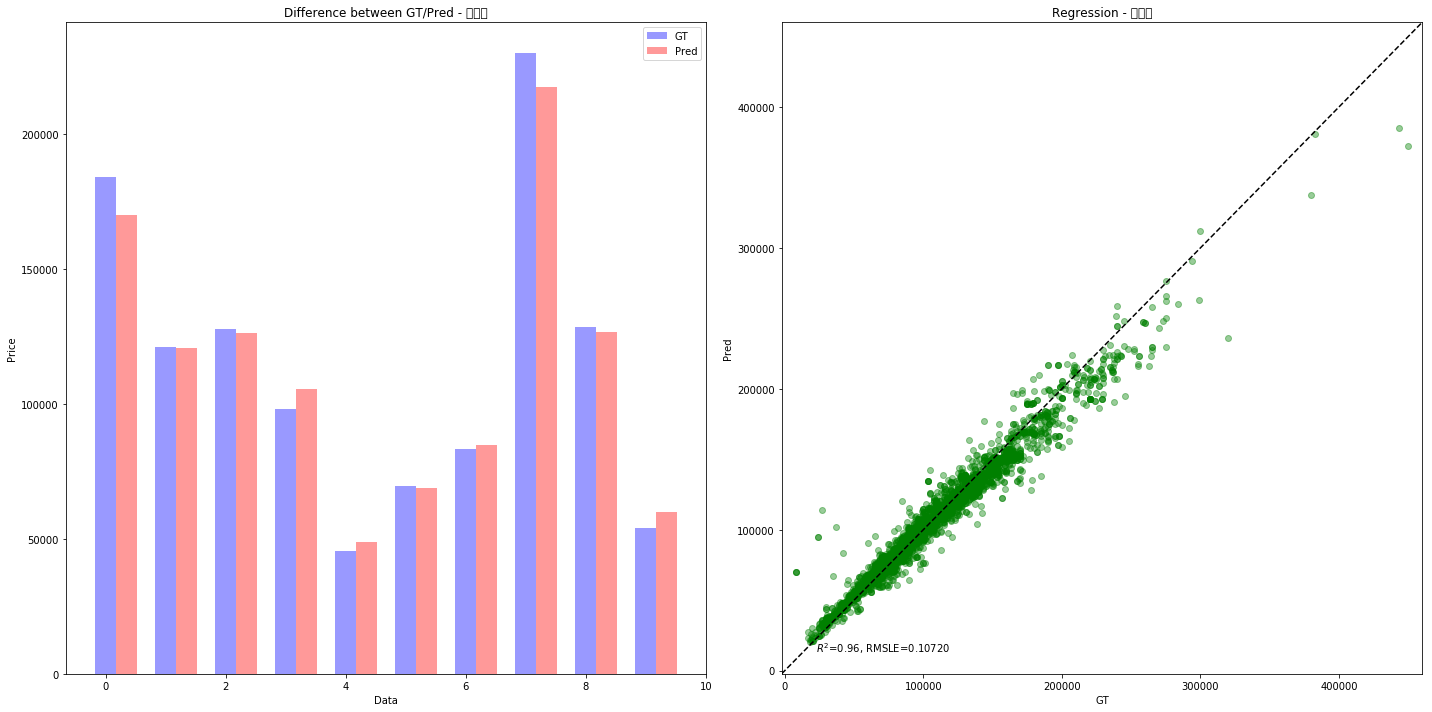

Max difference : 86832.28 만원
Mean difference : 5903.80 만원
--------
Avg Price of 강남구: 103793.44 만원
--------
R2 Coefficient : 0.962
RMLSE loss : 0.1072
MAPE : 6.7021


In [38]:
y_pred, diff = prediction_plot(10)